# 1. Unzip the ABCD data

https://www.notion.so/ABCD-Data-db3f7481eed54297a6f2b07a5a555ca3

`con_count`, `con_length` : 3487 개의 connection이다!

THE MATRIX : 84 variable Desikan-Killiany atlas이다!
file:///C:/Users/%ED%95%9C%EB%8F%99%EC%97%BD/Desktop/TVB_Windows_2.4.1/jnnp-2021-328185-inline-supplementary-material-1.pdf

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1.1. `phenotype` 에서 어떤 것을 가져올까?
`http://localhost:11115/edit/virtual_aging_brain/src/data.py` 에 있는 `metadata` method에서 필요로 하는 것들을 가져오면 된다. 따라서

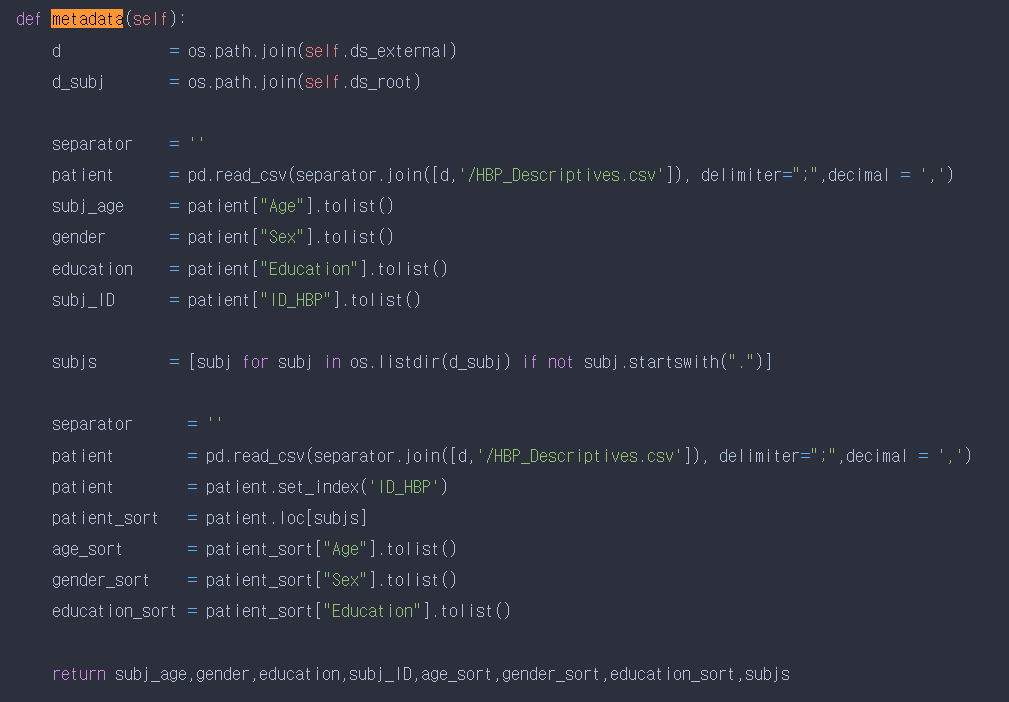
이것들이 필요함

따라서, 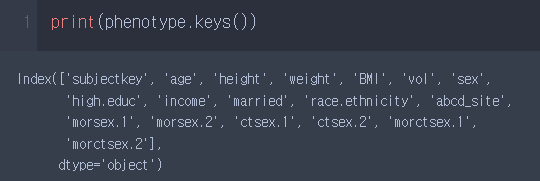
여기서 Index name들을 저 코드에서 필요로 하는 식으로 바꿔서 하자!

### 1.2. Now le'ts save the SC matrix

1. Weights가 ABCD는 1D로 되어있지만 이것을 2D로 다시 바꿔줘야함!
2. subject별로 2D array파일들을 각각 밑의 naming convention대로 저장해줘야함!
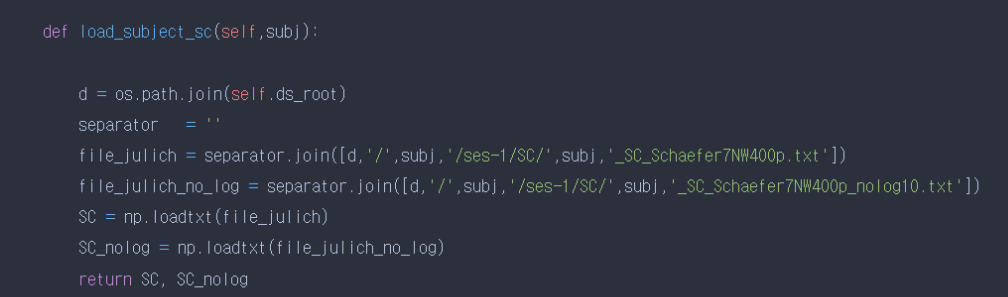


## MAKE SURE THE DATA ALSO 교집합 WITH fMRI (dMRI and demo.total의 겹치는 것만 확인함)

In [2]:
##IMPORTING DATA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
data_path = '/scratch/connectome/dyhan316/TVB/ABCD_data/'

###===step0: import the datas====###
phenotype=pd.read_csv(data_path+"demo.total.csv")
con_count=pd.read_csv(data_path+"con_aparc_count.csv")
con_length=pd.read_csv(data_path+"con_aparc_length.csv")


In [3]:
##SET OVERLAPPING STUFF AND CHANGE NAMES AND STUFF

print(phenotype.keys())
#print(phenotype['sex'])
phenotype = phenotype.rename(columns={'sex':"Sex",
                                          "age":"Age",
                                          "high.educ":"Education",
                                         "subjectkey":"ID_HBP"})

phenotype[['Sex',"Age","Education","ID_HBP"]]
print(phenotype.keys()) #new index names 

#setting the name to "ID_HBP"
phenotype.set_index('ID_HBP',inplace = True)
phenotype.index=phenotype.index.str.replace("_","") #changes _ with nothing


##일단 dMRI 얘내들도 그 subjectkey대신 `ID_HBP`를 이름으로 해두자!
con_count = con_count.rename(columns={"subjectkey":"ID_HBP"})
con_count.set_index('ID_HBP', inplace = True)

con_length = con_length.rename(columns={"subjectkey":"ID_HBP"})
con_length.set_index('ID_HBP', inplace = True)


###FC에들 이름들 불러오자
fc_input_dir = '/storage/bigdata/ABCD/fmriprep/1.rs_fmri/5.ROI_DATA/'
FC_subjs = [i[4:] for i in os.listdir(fc_input_dir)]
FC_subjs = pd.Series(FC_subjs)#, index = ["names"])

##이제 겹치는 애들만 골라내자! (DO THIS FOR fMRI TOO ONCE I GET THE DATA)
pheno_index=phenotype.index
con_len_index=con_length.index
con_count_index=con_count.index



merged = pheno_index.intersection(con_len_index) #merged index
merged = merged.intersection(con_count_index)
merged = merged.intersection(FC_subjs)

print("merged : ", merged)

phenotype = phenotype.loc[merged.values]
con_length = con_length.loc[merged.values]
con_count = con_count.loc[merged.values]

print("phenotype!!")
print(phenotype.head())
#print(con_length.head())
#print(con_count.head())

#2 : female, 1 : male 인데, 그걸 Female, Male로 해야한다!
male_mask = phenotype.Sex == 1
female_mask = phenotype.Sex == 2

print(male_mask, female_mask)

phenotype.loc[male_mask, "Sex"] = "Male" #conditional editing : using iloc or loc
phenotype.loc[female_mask, "Sex"] = "Female" #conditional editing : using iloc or loc

print(phenotype)
#phenotype['Age'] = phenotype['Age']+1 
#print(phenotype.head())










Index(['subjectkey', 'age', 'height', 'weight', 'BMI', 'vol', 'sex',
       'high.educ', 'income', 'married', 'race.ethnicity', 'abcd_site',
       'morsex.1', 'morsex.2', 'ctsex.1', 'ctsex.2', 'morctsex.1',
       'morctsex.2'],
      dtype='object')
Index(['ID_HBP', 'Age', 'height', 'weight', 'BMI', 'vol', 'Sex', 'Education',
       'income', 'married', 'race.ethnicity', 'abcd_site', 'morsex.1',
       'morsex.2', 'ctsex.1', 'ctsex.2', 'morctsex.1', 'morctsex.2'],
      dtype='object')
merged :  Index(['NDARINV003RTV85', 'NDARINV00BD7VDC', 'NDARINV00CY2MDM',
       'NDARINV00HEV6HB', 'NDARINV00LH735Y', 'NDARINV00LJVZK2',
       'NDARINV00NPMHND', 'NDARINV00R4TXET', 'NDARINV00U4FTRU',
       'NDARINV00UMK5VC',
       ...
       'NDARINVZZ4XNM65', 'NDARINVZZ6ZJ2KY', 'NDARINVZZ81LEEV',
       'NDARINVZZFG6J5U', 'NDARINVZZJ3A7BK', 'NDARINVZZLZCKAY',
       'NDARINVZZNX6W2P', 'NDARINVZZZ2ALR6', 'NDARINVZZZNB0XC',
       'NDARINVZZZP87KR'],
      dtype='object', name='ID_HBP', length=8238)

### Change 1D con/apart data => 2D matrix

In [4]:
## change 1D => 2D matrix##
positions = [[],[],[]] #2개가 아닌 3개인 이유 : 만약 특정 ROI가 뒤에만 있으면 detect가 안됨... 그래서 이렇게 해서 이것도 포함시키자
for names in con_count.keys():
    count = 0
    #print(names)
    for i,letters in enumerate(names):
        #print(letters)
        if "_"==letters:
            positions[count].append(i)
            #print(count)
            count = count+1
        if  count==3:
            break
print(con_count.keys())
print(len(positions))
print(len(positions[0]))
print(len(positions[1]))
print(len(positions[2]))

#save the names in `roi_set` pythnon set
roi_set = set()
for i in range(len(positions[0])): #여기서 몇개가 counting이 안됨!
    roi_set.add(con_count.keys()[i][positions[0][i]+1:positions[1][i]]) #앞에 있는 것 더하기
    roi_set.add(con_count.keys()[i][positions[1][i]+1:positions[2][i]]) #뒤에있는 것 더하기
    
print(roi_set)
print(len(roi_set),end="\n\n") #indeed, correct number of ROIs with correct names



#now let's list-izethe set and sort it alphabetically so that masking can later be done and shit (also the homotopic relationship thignie also too)
sorted_roi_list=sorted(list(roi_set))
print(sorted_roi_list)

#now let's use the sorted_roi_list to unflatten the 1D array
print("================")

#this will be looped later
subject_list = con_length.index
data_count_list =  []
data_len_list = []

#if needed, do the length thing too


import tqdm
#for i in tqdm.tqdm(range(1000)) : 
for i in tqdm.tqdm(range(len(subject_list))):
    
    #print(i)
    count_array = np.zeros((len(sorted_roi_list),len(sorted_roi_list))) -10 #empty array to store data
    len_array = np.zeros((len(sorted_roi_list),len(sorted_roi_list))) -10 #-10 to see anything wrong

    sub = subject_list[i] #will be looped later
    #print( "==========looking at subject : {}==========".format(sub))
    sub_count_data = con_count.loc[sub] #the series with the names and stuff 
    sub_len_data = con_length.loc[sub]

    for i,row in enumerate(sorted_roi_list):
        for j,column in enumerate(sorted_roi_list):
            if i==j:
                count_array[i,j]=0
                len_array[i,j]=0
                continue
            #print("i,j : ", i,j)
            count_connection_name = "con_"+row+"_"+column+"_count"
            #print(count_connection_name)
            len_connection_name = "con_"+row+"_"+column+"_length"

            try :
                sub_count_data[count_connection_name] #이것만 시도하면됨 (count값이 0이면 length값도 0으로 나옴)
            except:
                print(end="")
                #print("skipping ", count_connection_name)
            else :
                #print(sub_data[count_connection_name])
                count_array[i,j]=sub_count_data[count_connection_name]
                count_array[j,i]=sub_count_data[count_connection_name] #reverse connection도 doubly count 해야하니
                
                len_array[i,j] = sub_len_data[len_connection_name]
                len_array[j,i] = sub_len_data[len_connection_name]
    
    data_count_list.append(count_array)
    data_len_list.append(len_array)
    #print(count_array)
    #print(count_array.shape)
    #print("====================")
    #print(len_array)
    #print(len_array.shape)
    #print("# of left out : ",np.sum(count_array==-10)) #seeing if anything is left out (i.e. value of -10)
    #print("# of left out : ",np.sum(len_array==-10)) #seeing if anything is left out (i.e. value of -10)
    #print("========================")

data_count_log_list = [np.log10(data_tmp) for data_tmp in data_count_list]    
print([i.shape for i in data_count_list])
print([i.shape for i in data_len_list])
print([i.shape for i in data_count_log_list])
#let's look at the last stuff (last subject datas)
print("\n`count_array` : ")
print(count_array)

print("\n`len_array` : ")
print(len_array)


print("\n`count_log10_array` : ")
print(data_count_log_list[-1])
 

Index(['con_L-BSTS_L-CACG_count', 'con_L-BSTS_L-CMFG_count',
       'con_L-BSTS_L-CU_count', 'con_L-BSTS_L-EC_count',
       'con_L-BSTS_L-FG_count', 'con_L-BSTS_L-IPG_count',
       'con_L-BSTS_L-ITG_count', 'con_L-BSTS_L-ICG_count',
       'con_L-BSTS_L-LOG_count', 'con_L-BSTS_L-LOFG_count',
       ...
       'con_R-FP_R-TP_count', 'con_R-FP_R-TTG_count', 'con_R-FP_R-IN_count',
       'con_R-FP_R-CER_count', 'con_R-TP_R-TTG_count', 'con_R-TP_R-IN_count',
       'con_R-TP_R-CER_count', 'con_R-TTG_R-IN_count', 'con_R-TTG_R-CER_count',
       'con_R-IN_R-CER_count'],
      dtype='object', length=3486)
3
3486
3486
3486
{'R-IN', 'R-MTG', 'R-AM', 'R-CACG', 'R-PrCG', 'L-LOFG', 'L-ICG', 'L-PTR', 'R-PaCG', 'R-SPG', 'L-CER', 'R-TTG', 'R-ICG', 'L-CA', 'R-PCU', 'R-CA', 'L-AM', 'L-CU', 'R-PA', 'L-TH', 'R-CMFG', 'L-MTG', 'R-PU', 'L-PCAL', 'R-SMG', 'R-FP', 'R-LOG', 'L-LG', 'L-PCU', 'L-ITG', 'R-AC', 'R-CU', 'L-LOG', 'L-EC', 'R-PCAL', 'L-CMFG', 'L-PHIG', 'R-RMFG', 'L-TTG', 'L-PaCG', 'L-RMFG', 'L-FG',

100%|███████████████████████████████████████| 8238/8238 [26:46<00:00,  5.13it/s]
/tmp/ipykernel_3244386/298615614.py:94: RuntimeWarning: divide by zero encountered in log10
  data_count_log_list = [np.log10(data_tmp) for data_tmp in data_count_list]


[(84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84), (84, 84),

## Saving the Results

#### ONE POTENTIAL PROBLEM : THE log_list thing has -inf value => might cause problems....?

decimal=',' : 그 소숫점으로 ,를 썼기때문에, 저장할때 decimal = ','로 저장해줘야함 (b/c european data)

In [12]:
## SAVING THE RESULTS
#USE : `subject_list', 'data_count_list', 'data_len_list', `data_count_log_list`, `phenotype

#ONE POTENTIAL PROBLEM : THE log_list thing has -inf value => might cause problems....?
ds_root_path = '/scratch/connectome/dyhan316/TVB/virtual_aging_brain/data/external/Julich/'
ds_external = '/scratch/connectome/dyhan316/TVB/virtual_aging_brain/data/external/'
########1. save SC files#########
for i in tqdm.tqdm(range(len(data_count_list))):
#for i,subj in enumerate(subject_list[:1000]): 
    subj = subject_list[i]
    try:
        os.makedirs(ds_root_path+subj+'/ses-1/SC/') #not os.mkdir cuz gotta make all the intermediatry things too
        os.mkdir(ds_root_path+subj+'/ses-1/FC/')
    except:
        continue #skip subjects thtat were already done

    #print(subj, end = "  ")
    no_log_save_path = ds_root_path+subj+'/ses-1/SC/'+subj+'_SC_Schaefer7NW100p_nolog10.txt'
    log_save_path = ds_root_path+subj+'/ses-1/SC/'+subj+'_SC_Schaefer_7NW100p.txt'
    #print(no_log_save_path)
    np.savetxt(no_log_save_path, data_count_list[i] )
    np.savetxt(log_save_path, data_count_log_list[i])

print(np.loadtxt(no_log_save_path)) #successful!!
print("+++++++++++++++++++++++++++++++++")
########2. save ROI name files######### ('Schaefer2018_100Parcels_7Networks_tab.txt')
txt_name = 'Schaefer2018_100Parcels_7Networks_tab.txt'

sorted_roi_list_df = pd.DataFrame({"num" : np.arange(len(sorted_roi_list))+1,"roi": sorted_roi_list}) #+1 in num cuz start from 1 #becuase [1] are used
sorted_roi_list_df.to_csv(ds_external+txt_name, sep="\t", index=False, index_label=False,  header=None)#index_label=False, #index = False

##testing (using a part of the original /src/data.py code)
parce_frame    = pd.read_csv(ds_external+'Schaefer2018_100Parcels_7Networks_tab.txt', delimiter="\t",header=None)
print(parce_frame)
print(parce_frame[1].tolist())
#seems to work~!!


print("+++++++++++++++++++++++++++++++++++++")
########3. saving phenotype data###### ('/HBP_Descriptives.csv')
#patient      = pd.read_csv(separator.join([d,'/HBP_Descriptives.csv']), delimiter=";",decimal = ',')
use_sub_list = os.listdir(ds_root_path) #only use the things that are inside the dwi folder file! (다하지 말고)

#SAVING PART (ONLY SAVE THOSE THAT WERE SAVED IN THE DATA FILE)
phenotype.loc[use_sub_list].to_csv(ds_external+'HBP_Descriptives.csv', sep=';',decimal=',')

#실제로 testing해보는 것
separator=""
patient      = pd.read_csv(separator.join([ds_external,'/HBP_Descriptives.csv']), delimiter=";",decimal = ',')
subj_age     = patient["Age"].tolist()
gender       = patient["Sex"].tolist()
education    = patient["Education"].tolist()
subj_ID      = patient["ID_HBP"].tolist()

print(subj_age,gender,education,subj_ID)

#성공했다!!@!!!!!ㅏ!!ㅏ:ㄴ아ㅣ러~!!!

100%|██████████████████████████████████████| 8238/8238 [00:23<00:00, 356.05it/s]


[[  0.  19.   0. ...   3.   0.   0.]
 [ 19.   0.   1. ...   5.   0.   0.]
 [  0.   1.   0. ...   0.   0.   0.]
 ...
 [  3.   5.   0. ...   0.   1. 110.]
 [  0.   0.   0. ...   1.   0.   0.]
 [  0.   0.   0. ... 110.   0.   0.]]
+++++++++++++++++++++++++++++++++
     0       1
0    1    L-AC
1    2    L-AM
2    3  L-BSTS
3    4    L-CA
4    5  L-CACG
..  ..     ...
79  80   R-SPG
80  81   R-STG
81  82    R-TH
82  83    R-TP
83  84   R-TTG

[84 rows x 2 columns]
['L-AC', 'L-AM', 'L-BSTS', 'L-CA', 'L-CACG', 'L-CER', 'L-CMFG', 'L-CU', 'L-EC', 'L-FG', 'L-FP', 'L-HI', 'L-ICG', 'L-IN', 'L-IPG', 'L-ITG', 'L-LG', 'L-LOFG', 'L-LOG', 'L-MOFG', 'L-MTG', 'L-PA', 'L-PCAL', 'L-PCG', 'L-PCU', 'L-PHIG', 'L-POP', 'L-POR', 'L-PTR', 'L-PU', 'L-PaCG', 'L-PoCG', 'L-PrCG', 'L-RACG', 'L-RMFG', 'L-SFG', 'L-SMG', 'L-SPG', 'L-STG', 'L-TH', 'L-TP', 'L-TTG', 'R-AC', 'R-AM', 'R-BSTS', 'R-CA', 'R-CACG', 'R-CER', 'R-CMFG', 'R-CU', 'R-EC', 'R-FG', 'R-FP', 'R-HI', 'R-ICG', 'R-IN', 'R-IPG', 'R-ITG', 'R-LG', 'R-LOFG', 'R

In [9]:
print(len(subject_list))
print(len(data_count_list))

8238
8238


In [ ]:
import pandas as pd
import numpy as np
print(pd.DataFrame({"num" : np.arange(10)+1,"roi": np.arange(10)})) #becuase [1] are used)

In [ ]:
hahahaha #intended to cause error so below doesn't initiate

In [ ]:
'''

import csv


sorted_roi_list_pd = pd.Series(sorted_roi_list)
sorted_roi_list_pd.to_csv(ds_external+txt_name, sep="\t", index=False, index_label=False,  header=None)#index_label=False, #index = False

#print(pd.read_csv(ds_external+txt_name)) #works well
parce_frame    = pd.read_csv(ds_external+'Schaefer2018_100Parcels_7Networks_tab.txt', delimiter="\t",header=None)
print(parce_frame)
#print(parce_frame[1].tolist())
#parce_list     = parce_frame[1].tolist()
#print(parce_list)
try_stuff = pd.DataFrame({"num" : np.arange(len(sorted_roi_list)),"roi": sorted_roi_list})
try_stuff.to_csv(ds_external+txt_name, sep="\t", index=False, index_label=False,  header=None)#index_label=False, #index = False
print(try_stuff)
#print(pd.read_csv(ds_external+txt_name)) #works well
parce_frame    = pd.read_csv(ds_external+'Schaefer2018_100Parcels_7Networks_tab.txt', delimiter="\t",header=None)
print(parce_frame)
print(parce_frame[1].tolist())
#parce_list     = parce_frame[1].tolist()
#print(parce_list)





#to_csv로 하면 txt로 된다~!


os.listdir('/scratch/connectome/dyhan316/TVB/virtual_aging_brain/data/external/Julich/')
print(phenoty)
#np.savetxt('/scratch/connectome/dyhan316/TVB/virtual_aging_brain/data/external/Julich/haha.txt',[2,2,2])'''

In [ ]:
### 위에서 했던것 한명에 대해서만 하는 것 
#this will be looped later

subject_list = con_length.index
sub = subject_list[0] #will be looped later
print(sub)
#print(con_count)
sub_data = con_count.loc[sub] #the series with the names and stuff 

#count_array, len_array
print(sub_data)
print(sub_data.index)
#print(sub_data['con_L-BSTS_L-CACG_count'])
print(sorted_roi_list)
haha=[]
for i,row in enumerate(sorted_roi_list):
    for j,column in enumerate(sorted_roi_list):
        if i==j:
            count_array[i,j]=0
            continue
        #print("i,j : ", i,j)
        count_connection_name = "con_"+row+"_"+column+"_count"
        #print(count_connection_name)
        len_connection_name = "con_"+row+"_"+column+"_length"
        
        try :
            sub_data[count_connection_name]
        except:
            print(end="")
            #print("skipping ", count_connection_name)
        else :
            #print(sub_data[count_connection_name])
            count_array[i,j]=sub_data[count_connection_name]
            count_array[j,i]=sub_data[count_connection_name] #reverse connection도 doubly count 해야하니

print(count_array)
print("# of left out : ",np.sum(count_array==-10)) #seeing if anything is left out (i.e. value of -10)

#plotting stuff
fig, ax = plt.subplots(1,1)
img = ax.imshow(count_array)

fig.set_size_inches(50,50)
ax.set_xticks(np.arange(84))
ax.set_xticklabels(sorted_roi_list)

ax.set_yticks(np.arange(84))
ax.set_yticklabels(sorted_roi_list)


fig.colorbar(img)

###checking the results to see if it's correct (the variance issue is because there are additional thigns (self edges),so not exactly the same variance)
print("count_array : sum={}, variance={}".format(np.sum(count_array),np.var(count_array)))
print("sub_data : sum={}, variance={}".format(sub_data.sum(),sub_data.var()))
print("their difference, sum_ratio={},var_ratio={}".format(np.sum(count_array)/sub_data.sum(),np.var(count_array)/sub_data.var()))
print(len(sorted_roi_list))
print(len(sub_data))

In [ ]:
print(len(['L-AC', 'L-AM', 'L-BSTS', 'L-CA', 'L-CACG', 'L-CER', 'L-CMFG', 'L-CU', 'L-EC', 'L-FG', 'L-FP', 'L-HI', 'L-ICG', 'L-IN', 'L-IPG', 'L-ITG', 'L-LG', 'L-LOFG', 'L-LOG', 'L-MOFG', 'L-MTG', 'L-PA', 'L-PCAL', 'L-PCG', 'L-PCU', 'L-PHIG', 
       'L-POP', 'L-POR', 'L-PTR', 'L-PU', 'L-PaCG', 'L-PoCG', 'L-PrCG', 'L-RACG', 'L-RMFG', 'L-SFG', 'L-SMG', 'L-SPG', 'L-STG', 'L-TH', 'L-TP', 'L-TTG']))

print(len(['R-AC', 'R-AM', 'R-BSTS', 'R-CA', 'R-CACG', 'R-CMFG', 'R-CU', 'R-EC', 'R-FG', 'R-FP', 'R-HI', 'R-ICG', 'R-IN', 'R-IPG', 'R-ITG', 'R-LG', 'R-LOFG', 'R-LOG', 'R-MOFG', 'R-MTG', 'R-PA', 'R-PCAL', 'R-PCG', 'R-PCU', 'R-PHIG', 'R-POP',
           'R-POR', 'R-PTR', 'R-PU', 'R-PaCG', 'R-PoCG', 'R-PrCG', 'R-RACG', 'R-RMFG', 'R-SFG', 'R-SMG', 'R-SPG', 'R-STG', 'R-TH', 'R-TP', 'R-TTG']))


print(con_count.columns[80:])


In [ ]:
print(phenotype.index)
print(con_length.index)
print(con_count.index)

pheno_index=phenotype.index
con_len_index=con_length.index
con_count_index=con_count.index

merged=pheno_index.intersection(con_len_index)
merged=merged.intersection(con_count_index)

print(merged)

print(merged.values)

print(phenotype.loc[merged.values])

In [ ]:
print(wholedata)

In [ ]:
for i in wholedata:
    i.set_index('subjectkey',inplace=True)#BECAREFUL!!!(inplace is needed!!)
phenotype.index=phenotype.index.str.replace("_","") #changes _ with nothing

'''====step1: set the index as the subject key==='''
for i in wholedata:
    i.set_index('subjectkey',inplace=True)#BECAREFUL!!!(inplace is needed!!)


data_sex=phenotype['sex'] #only extract the phenotype data

wholedata[0]=data_sex #set data_sex as new
print(wholedata)

'''=====step2: concatenate the data===(along axis=1, with only the intersections'''
total=pd.concat([i for i in wholedata],axis=1,join="inner") 
#겹치는 애들만 빼내기
#WITH SEX AS ONE OF THE TINGS
print("============================================")
print(total)

###자 이제 그 필요한 곳에다가 저자ㅣㅇ하고 하자 

In [ ]:
#Extract_Data_2.py
import pandas as pd
import numpy as np

'''===step0: import the datas===='''

phenotype=pd.read_csv("demo.total.csv")
con_count=pd.read_csv("con_aparc_count.csv")
con_fa=pd.read_csv("con_aparc_fa.csv")
con_length=pd.read_csv("con_aparc_length.csv")
con_rd=pd.read_csv("con_aparc_rd.csv")
#if I want to use the absolute file, i need to put r in front of the string (see link below)
#used https://stackoverflow.com/questions/37400974/unicode-error-unicodeescape-codec-cant-decode-bytes-in-position-2-3-trunca#

wholedata=[phenotype,con_count,con_fa,con_length,con_rd] #for use in for loops


'''====step1: set the index as the subject key==='''
for i in wholedata:
    i.set_index('subjectkey',inplace=True)#BECAREFUL!!!(inplace is needed!!)
    #this is the same as
    #i=i.set_index('subjectkey')

'''
**below: to see if the subjectkeys have successfully been made into the index
for i in wholedata:
    print(i.head())
'''
#extra step 0: phenotype subject key is weird: so change it
phenotype.index=phenotype.index.str.replace("_","") #changes _ with nothing


data_sex=phenotype['sex'] #only extract the phenotype data


wholedata[0]=data_sex #set data_sex as new
#meta-data of data_sex Series로 "sex"가 있기에 굳이 column name을 지정해줄 필요가 없음
#(원래는 Series에는 column name이 없으니 따로 지정해줘야하는줄 알았다)
'''=====step2: concatenate the data===(along axis=1, with only the intersections'''
total=pd.concat([i for i in wholedata],axis=1,join="inner") #join inner means only taking key values that appear in both cases

#total is the final thing we want!

'''=====step4: check for NaN values and remove samples with that '''
print((np.count_nonzero(total.isnull()))) #we can see that lots of null values exist!!

total.dropna(inplace=True) #inplace=True so that the total itself is changed
#axis=0 by default, how='any' by default,
#for reference, look at :https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

print((np.count_nonzero(total.isnull()))) #prints zero, as expected (no null values)

total.to_csv("DATA.csv")#saves in the current cwd with file name I provide (and also the extension (.csv) I provide)





#todo: read https://intellij-support.jetbrains.com/hc/en-us/community/posts/360004715019-My-python-file-will-execute-code-from-another-python-file-and-when-I-deleted-the-file-the-code-was-excuted-from-other-files-it-gave-me-an-error

#todo: 학교 tech support에 전화해서 microsoft word다시 작동하게 하기(논문작성 마무리해야함)



In [ ]:
'''
sns.set()

a=np.array([10])
data=pd.read_csv("DATA.csv", index_col='subjectkey') #imported the data #set index as subjectkey

#====step0: divide into features_matrix/target arrays (training등으로 바꾸는건 나중에)
output=data['sex']
input=data.drop(['sex'], axis=1) #drop column, so axis=1

#===========step0-1: see the min/max values of each column to see if they are normalized========

aa=input.mean(axis=0) #이렇게 하면 column별로의 average를 볼 수 있는 것 같다

#이제 이 aa를 plot하든 distribution을 보든지 해서, 값이 일정 range안에 모두 존재하는지 보자
#만약 값들이 scale이 다르면 normalization을 거쳐야 할듯

plt.hist(aa.values,bins=10)
plt.show()
#너무나도 큰 값의 차이가 보이기에, normalization을 거처야 할듯하다.

#====step0-2. Go through normalizatoin(?) to tame it a bit
#값들이 0이상이니 그냥 arctanh()로 하자
input=np.tanh(input) #normalize the inputs using tanh

#open this when I us eit
input.to_csv("input.csv")#saves in the current cwd with file name I provide (and also the extension (.csv) I provide)
output.to_csv("output.csv")#saves in the current cwd with file name I provide (and also the extension (.csv) I provide)

'''